# Project Description

## Goal:

Analyze customer profiles and come up with a customer retention strategy.

We will:
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
     - Identify target groups
     - Suggest measures to cut churn
     - Describe any other patterns you see with respect to interaction with customers
     
## Steps:
**[1. Step 1. Download the data](#Step-1.-Download-the-data)**

**[2. Step 2. Carry out exploratory data analysis (EDA)](#Step-2.-Carry-out-exploratory-data-analysis-(EDA))**
- Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).
- Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).
- Plot bar histograms and feature distributions for those who left (churn) and those who stayed.
- Build a correlation matrix and display it.

**[3. Step 3. Build a model to predict user churn](#Step-3.-Build-a-model-to-predict-user-churn)**
Build a binary classification model for customers where the target feature is the user's leaving next month.
- Divide the data into train and validation sets using the train_test_split() function.
- Train the model on the train set with two methods:
    - logistic regression
    - random forest
- Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?

**[4. Step 4. Create user clusters](#Step-4.-Create-user-clusters)**
- Standardize the data.
- Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. Note: rendering the dendrogram may take time! Use the resulting graph to estimate the number of clusters you can single out.
- Train the clustering model with the K-means algorithm and predict customer clusters. 
- Look at the mean feature values for clusters. Does anything catch your eye?
- Plot distributions of features for the clusters. Do you notice anything?
- Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

**[5. Step 5. Come up with conclusions and basic recommendations on working with customers](#Step-5.-Come-up-with-conclusions-and-basic-recommendations-on-working-with-customers)**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
import time

### Step 1. Download the data

In [2]:
data = pd.read_csv('/datasets/gym_churn_us.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Step 2. Carry out exploratory data analysis (EDA)

#### Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).

In [3]:
data.shape

(4000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

- We see that we have 4000 customer profiles which include 13 different features + Target feature `Churn`
- There are no missing values in the data
- Data types seems fine as they are either floats or integers (no categorical data)

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


- We see that we have either binary values and numerical values
- Based on the mean, median and standard deviation for the data we see that most of the feature values are distributed fairly normally with some large outliers for a couple of features

In [6]:
np.percentile(data['Avg_additional_charges_total'], [90, 95, 96, 97, 98, 99])

array([277.7171989 , 323.44087589, 334.4735449 , 349.36370877,
       369.13368039, 400.99612505])

In [7]:
np.percentile(data['Lifetime'], [90, 95, 96, 97, 98, 99, 99.5])

array([ 9., 11., 12., 13., 15., 17., 20.])

In [8]:
limit_1 = np.percentile(data['Avg_additional_charges_total'],95)
limit_2 = np.percentile(data['Lifetime'],90)
#data = data.query('Avg_additional_charges_total <= @limit ')

In [9]:
data['Avg_additional_charges_total'].where(data['Avg_additional_charges_total'] <= limit_1, limit_1, inplace=True)
data['Lifetime'].where(data['Lifetime'] <= limit_2, limit_2, inplace=True)

In [10]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,144.509001,4.322750,3.387750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,90.547449,4.191297,2.812895,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,323.440876,12.000000,9.000000,6.023668,6.146783,1.000000


- As we will be using Logistic Regression (sorts of a linear model) it will be better to process then outliers as to not affect the model 
- Most obvious outliers are in column `Avg_additional_charges_total` so we will process them and as we don't have a large number of profiles we replaced them with the maximum value for this feature which was chosen as the 95 percentile of the original values.
- We did the for the column `Lifetime` and replaced them with the maximum value for this feature which was chosen as the 90 percentile of the original values.
- After replacing the oultiers with the chosen maximum value, we have a mean closer to the median and smaller standard deviation which indicates less variations and a better distribution of values for both features.

#### Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).

In [11]:
churn_grouped = data.groupby('Churn').mean()

In [12]:
churn_grouped

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,155.209882,5.283089,4.253147,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,114.867260,1.662582,0.990575,1.474995,1.044546


- We notice that for some features the mean values for those who left and those who stayed are relatively different which indicates that those feature have a stronger effect on churn_rate than others for examplle: 
   - `Contract_period` and `Month_to_end_contract`
   - `Avg_additional_charges_total`
   - `Lifetime`
   - `Avg_class_frequency_total` and `Avg_class_frequency_current_month`
   - `Group_visits`
- There are also some features who have some difference but on a smaller level like: 
   - `Partner`
   - `Promo_friends`
   - `Age`
- While some have almost the same mean vlaues for both groups or a very small difference so we can assume that they have no impact on churn like: 
   - `gender`
   - `Near_Location`
   - `Phone`

#### Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

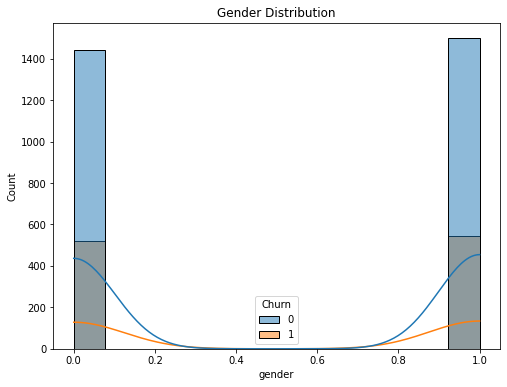

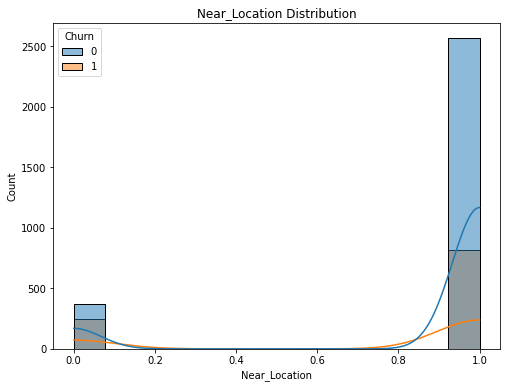

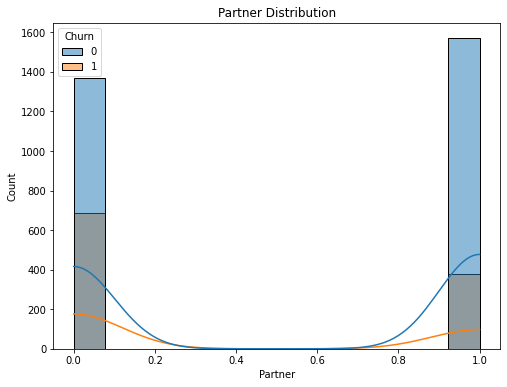

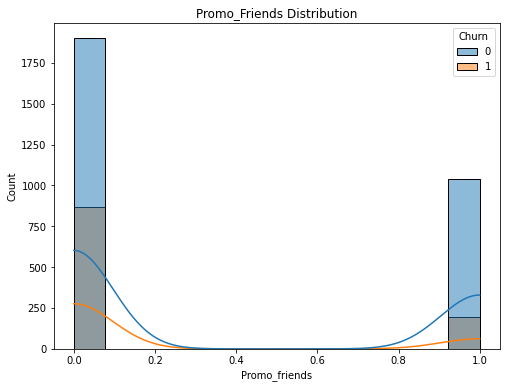

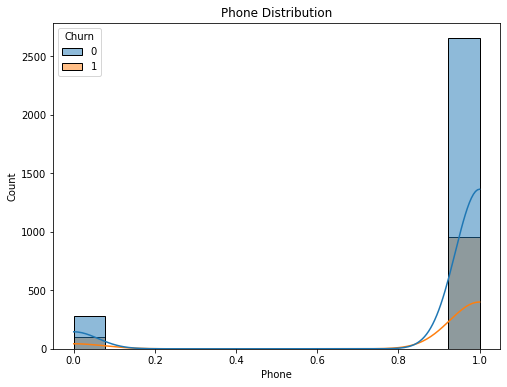

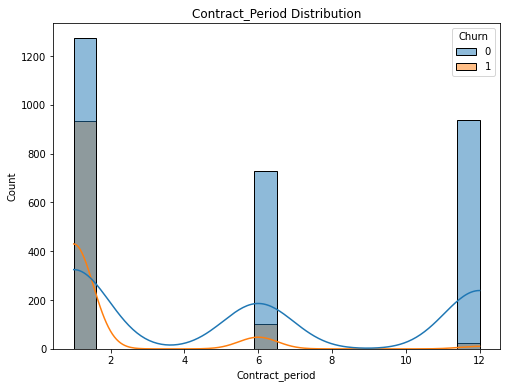

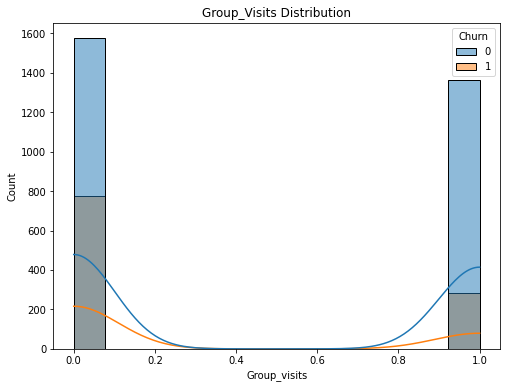

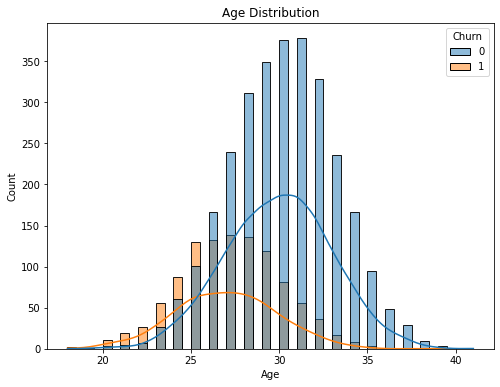

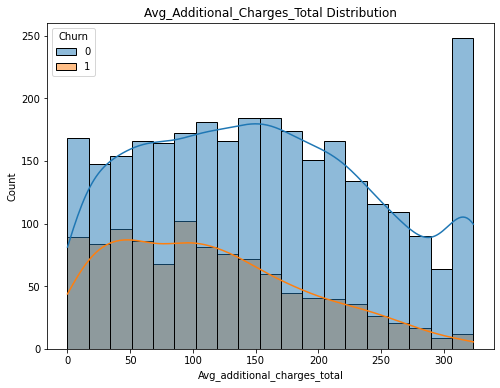

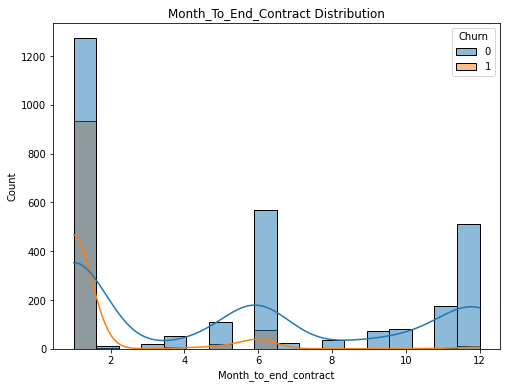

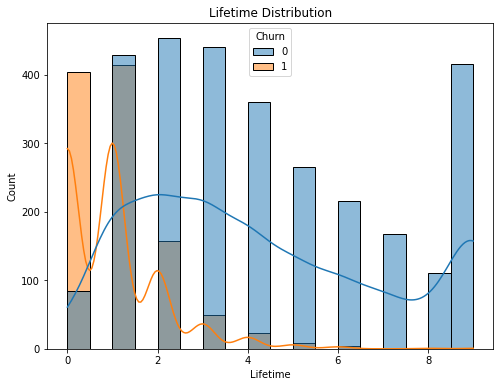

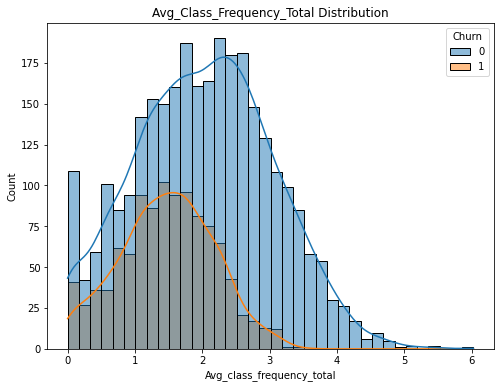

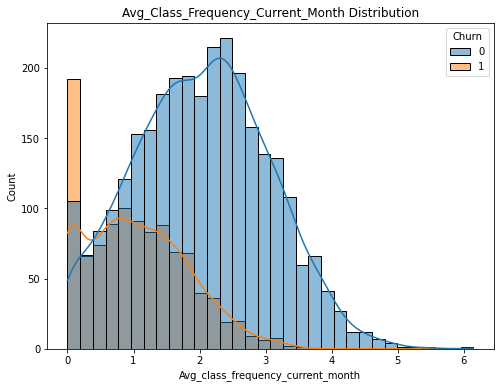

In [13]:
for i in data.columns:
    if i != 'Churn':
        plt.figure(figsize = (8,6))
        sns.histplot(data = data, kde=True, x=i, hue= 'Churn')
        plt.title(f'{i.title()} Distribution');
        plt.show()

The Graphs show the same results, some features have some distinction between who left (churn) and who stayed and they are the same as what we found previously

#### Build a correlation matrix and display it.

In [14]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [15]:
data_correlataion = data.corr()

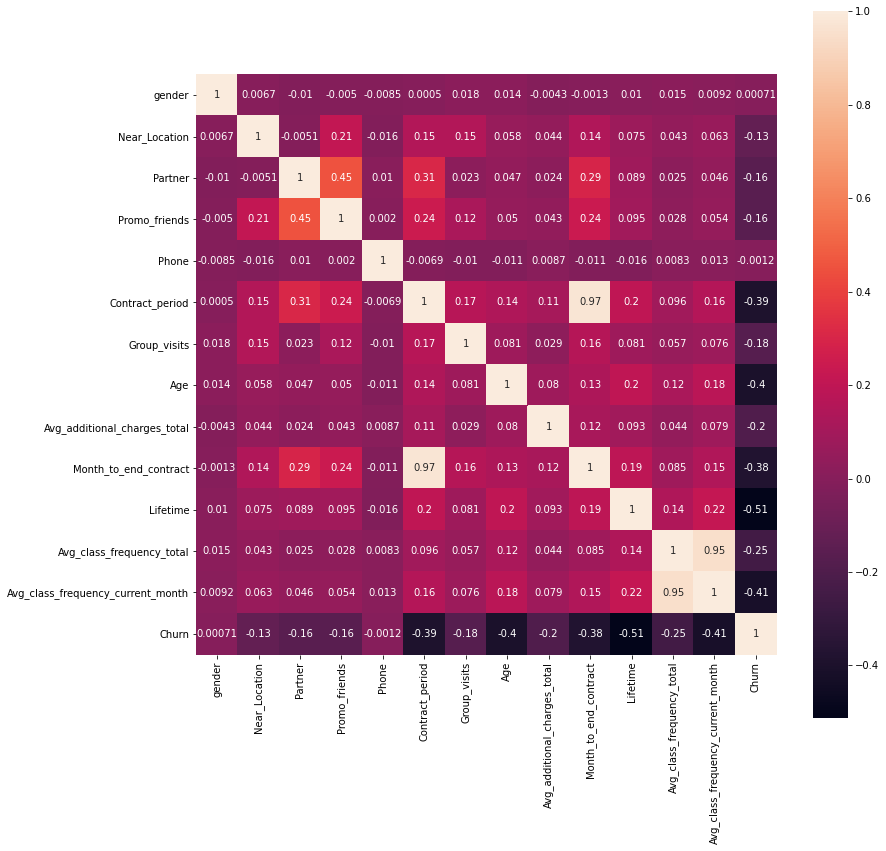

In [16]:
plt.figure(figsize= (13,13))
sns.heatmap(data_correlataion, annot = True, square=True);

- From the correlation Matrix Heatmap we notice that we have 2 pairs of strongly correlated features:
   - `Contract_period` and `Month_to_end_contract`
   - `Avg_class_frequency_total` and `Avg_class_frequency_current_month`
- We see that we have some feautres that have correlated relations with the Target Feature, but all of them have a "Pearson correlation coefficient" vlaue of 0.5 or less

### Step 3. Build a model to predict user churn

#### Divide the data into train and validation sets using the train_test_split() function.

In [17]:
y = data['Churn']
X = data.drop('Churn', axis = 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)

- We split thge data with 80/20 Ratio train to test 
- We chose a random split as we don't have a time_based data 
- We chose a random-state as to keep the splitting consistant through out our study

#### Train the model on the train set with the two methods:

In [19]:
# List of chosen Methods
models = [LogisticRegression(), RandomForestClassifier()]

In [20]:
# function to train the model and makes prediction then print the Metrics
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}, Precision: {precision_score (y_test, y_pred)}, Recall: {recall_score (y_test, y_pred)}')

In [21]:
# Loop for itterating through the list of models and apply our function to them
for i in models:
    print(i)
    make_prediction(i,X_train, y_train, X_test, y_test)

LogisticRegression()
Accuracy: 0.9275, Precision: 0.8823529411764706, Recall: 0.8411214953271028
RandomForestClassifier()


c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.92, Precision: 0.8826530612244898, Recall: 0.8084112149532711


- Both models performed well.
- Both Methods are fairly similar with a slight different in favor of `LogisticRegression` method over `RandomForest` method especially for "Recall" metric.
- Based on the previous results it is better to continue working with `LogisticRegression` . 

### Step 4. Create user clusters

**Note:** we already have a Dataset where we sat aside the column with data on churn ("X" from when we trained a model for predicting the churn)


#### Standardize the data.

In [22]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#### Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram.

In [23]:
linked = linkage(X_sc, method = 'ward') 

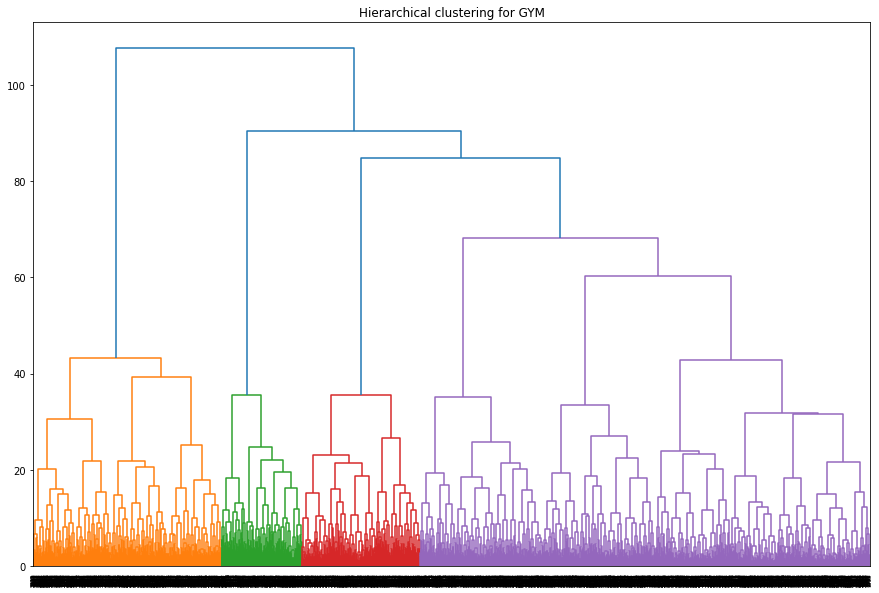

time needed: 141.8453562259674


In [24]:
start_time = time.time()
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show() 
print(f'time needed: {time.time() - start_time}')    

- Based on the Dendrogram above we can estimate that we form 4 Clusters ( split the customers into 4 groups)

#### Train the clustering model with the K-means algorithm and predict customer clusters.

- As intructed we will continue our work and form (5 clusters)

In [25]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)

In [26]:
data['cluster_km'] = labels

In [27]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,2


#### Look at the mean feature values for clusters.

In [28]:
cluster_mean = data.groupby(['cluster_km']).mean().reset_index()

In [29]:
cluster_mean

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.494048,0.000000,0.462302,0.079365,1.000000,2.343254,0.218254,28.460317,133.718748,2.196429,2.611111,1.660084,1.476774,0.444444
1,1,0.505429,0.958539,0.781836,0.567621,1.000000,10.892399,0.543929,29.994077,158.490169,9.947680,4.293189,1.974995,1.967514,0.024679
2,2,0.485044,1.000000,0.345190,0.236055,1.000000,1.951496,0.340340,28.134196,129.332236,1.863379,2.188359,1.242674,1.003321,0.529507
3,3,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,141.851440,4.475325,3.511688,1.847220,1.716369,0.267532
4,4,0.556330,0.976771,0.364692,0.242741,0.998839,2.616725,0.468060,30.111498,157.368681,2.414634,4.444832,2.822717,2.821036,0.062718


#### Plot distributions of features for the clusters

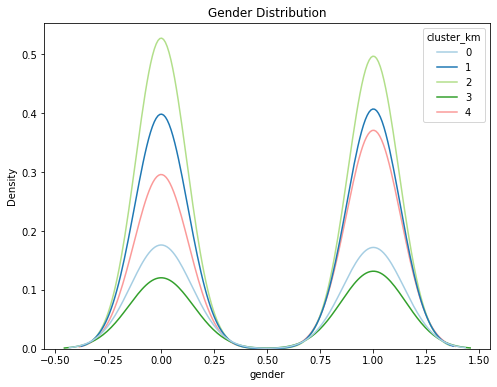

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


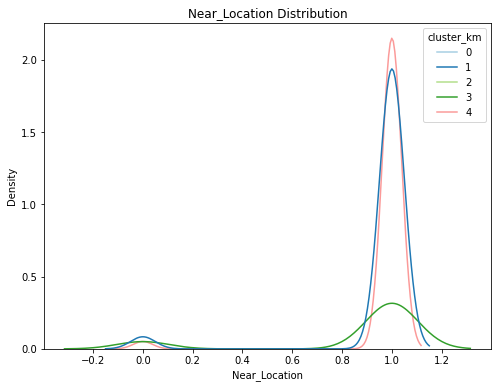

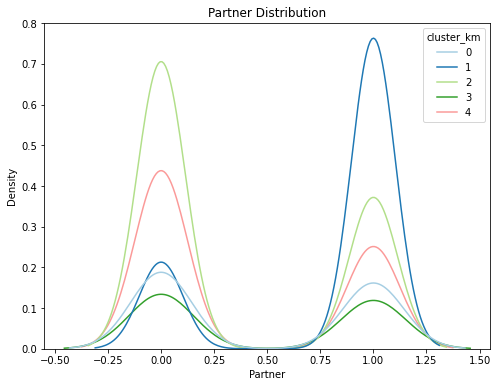

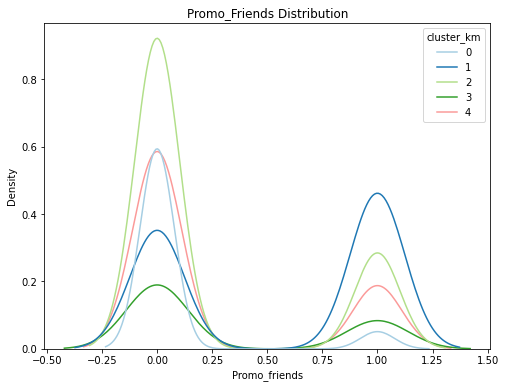

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


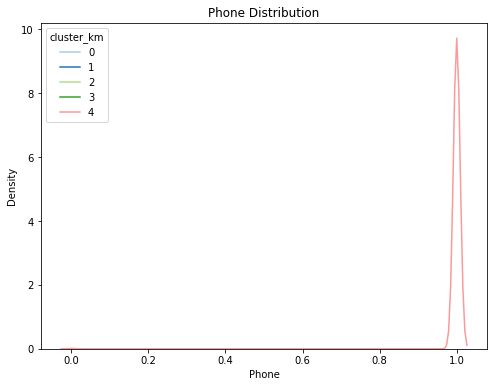

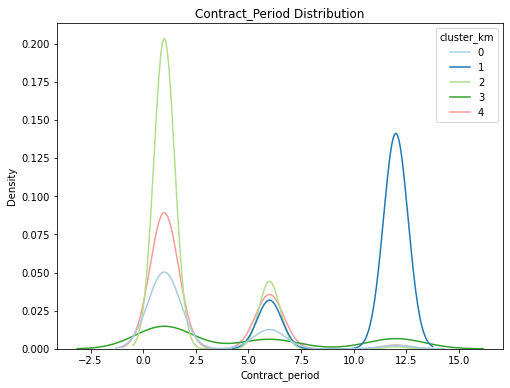

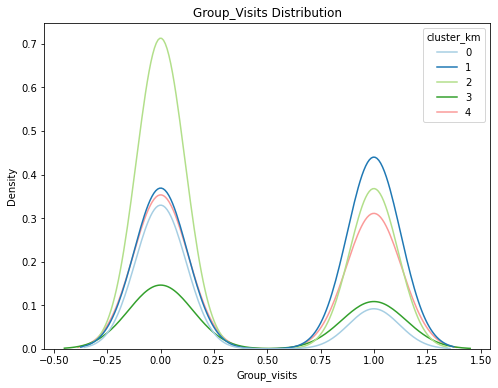

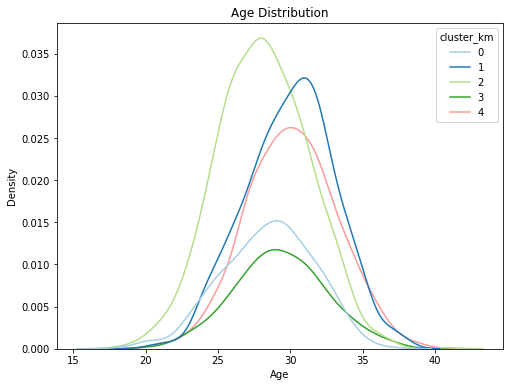

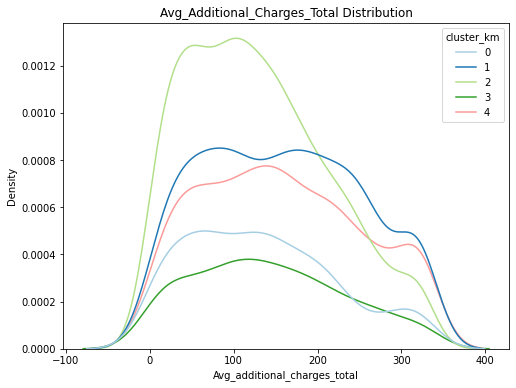

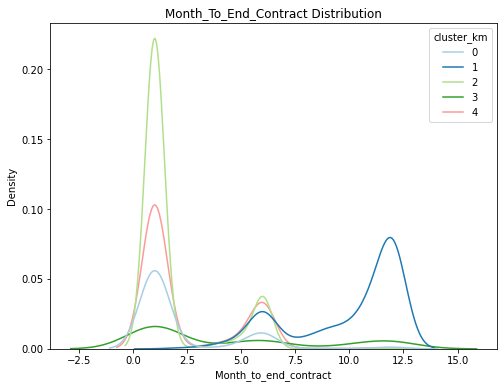

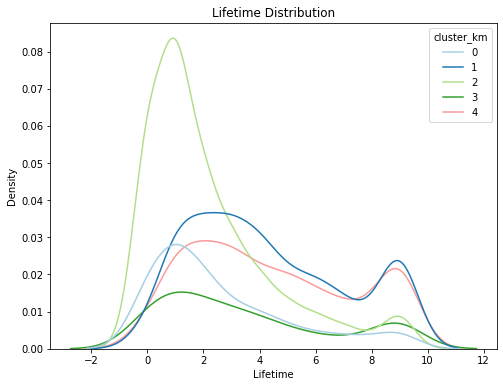

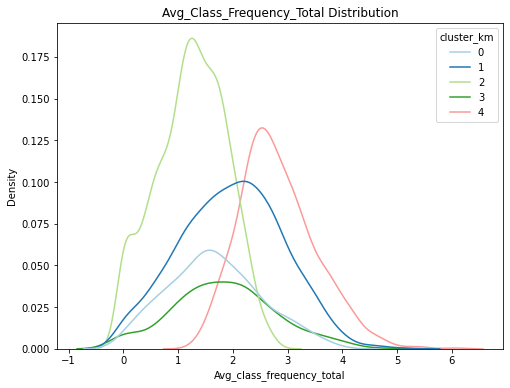

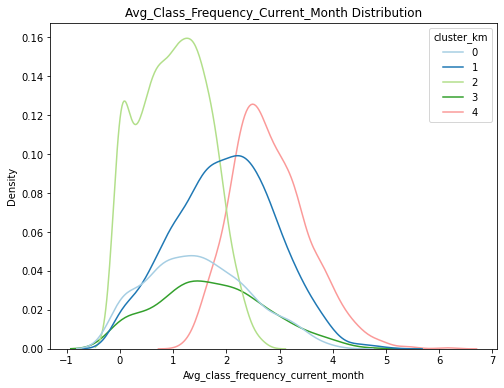

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


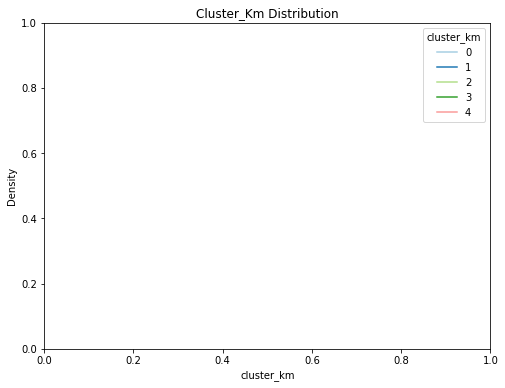

In [30]:
for i in data.columns:
    if i != 'Churn':
        plt.figure(figsize = (8,6))
        sns.kdeplot(data = data,x=i, palette = 'Paired', hue= 'cluster_km')
        plt.title(f'{i.title()} Distribution');
        plt.show()

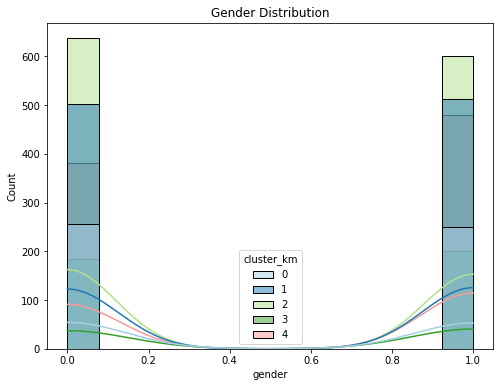

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


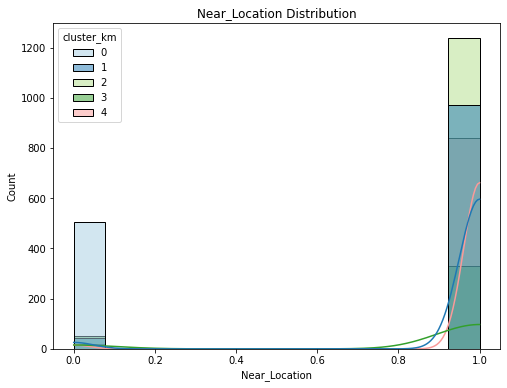

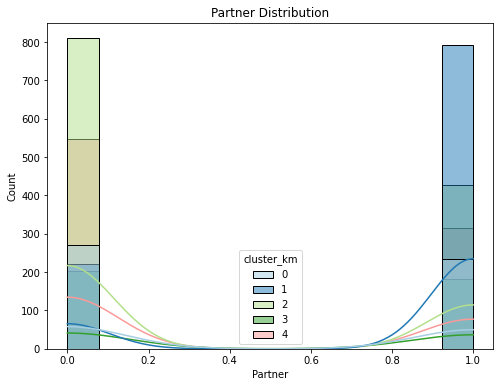

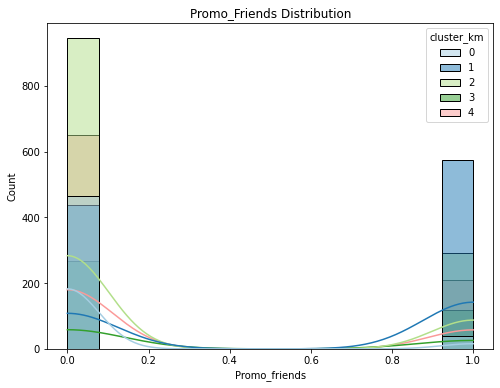

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


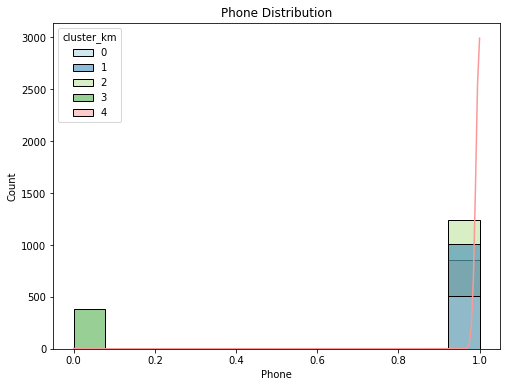

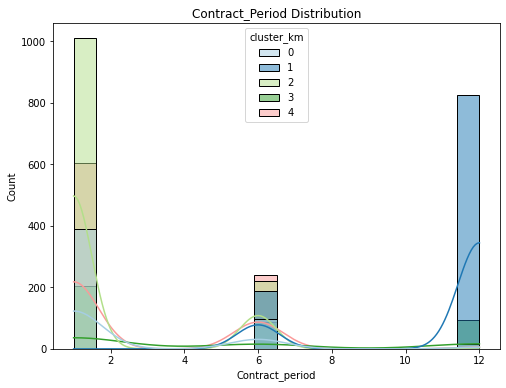

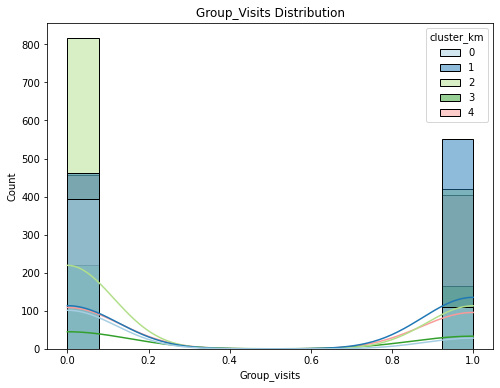

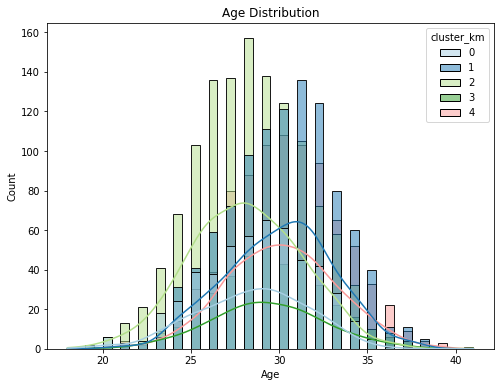

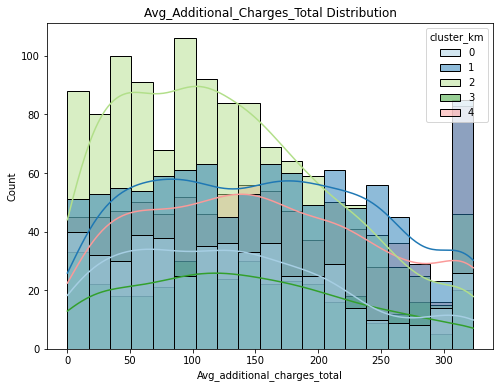

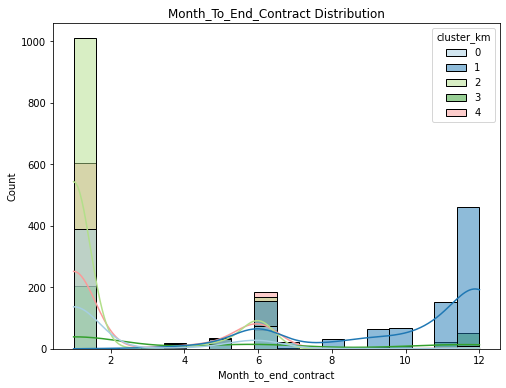

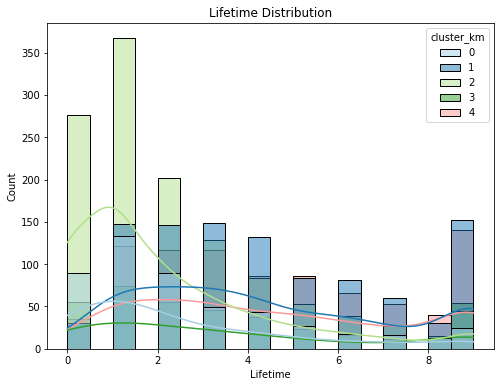

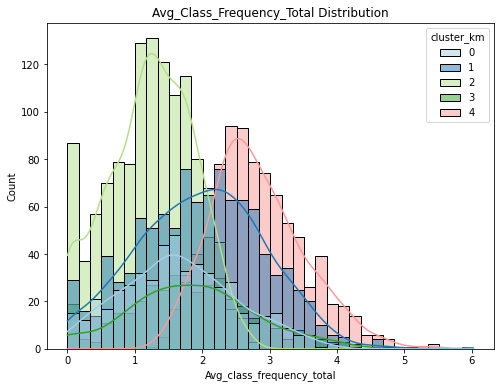

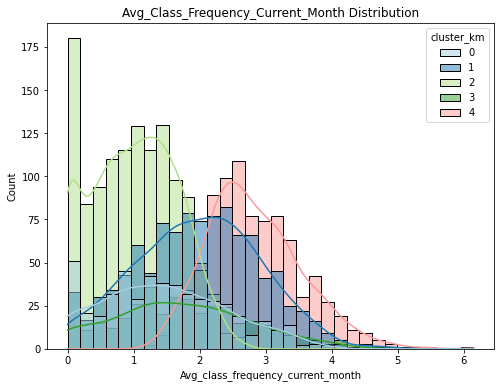

c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\abdel\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


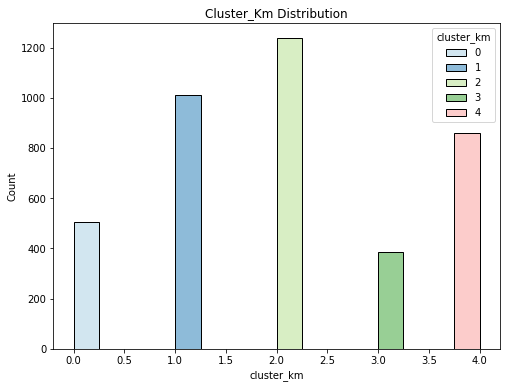

In [31]:
for i in data.columns:
    if i != 'Churn':
        plt.figure(figsize = (8,6))
        sns.histplot(data = data, kde=True, x=i, palette = 'Paired', hue= 'cluster_km')
        plt.title(f'{i.title()} Distribution');
        plt.show()

In [32]:
silhouette_score(X_sc, labels) 

0.14016528557189106

- Based on the graphs above we notice that some clusters especially "E" have lower means for the features in comparision to the other clusters
- We also notice that cluster "E" has the highest number of profiles (more than 25%) of the profiles belong to this group
- All of the traits mentioned previously can be seen clearly using the distribution graph of each feature.
- By looking at the silhouette_score (silhouette_score = 0.14 "for the run studied") we notice that the score is relatively low but still positive which indicates that the clustering doesn't have a high quality but still good.

#### Calculate the churn rate for each cluster 

In [33]:
cluster_churn = data.groupby('cluster_km')['Churn'].apply(lambda x: 100* x.sum() / x.count())

In [34]:
cluster_churn

cluster_km
0    44.444444
1     2.467917
2    52.950687
3    26.753247
4     6.271777
Name: Churn, dtype: float64

- We can see that the clusters "A" and "B" have the lowest and a very low churn_rate which makes sense as they have the highest mean for the features that indicate active users.
- On the other hand "D" and "E" have the highest churn_rate which is also make sense as for the first goup they all live far from the gym which is a potential hurdle and group "E" has the lowest mean of all activity feature which makes most of its members inactive or casual users.
- group "C" has a churn_rate in the middle between the previous groups, therefore we can't say that not including the phone in the data is a sign for inactivity or quitting as this group still have higher ratio of active users than groups "D" and "E"

In [35]:
cluster_mean

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,0.494048,0.000000,0.462302,0.079365,1.000000,2.343254,0.218254,28.460317,133.718748,2.196429,2.611111,1.660084,1.476774,0.444444
1,1,0.505429,0.958539,0.781836,0.567621,1.000000,10.892399,0.543929,29.994077,158.490169,9.947680,4.293189,1.974995,1.967514,0.024679
2,2,0.485044,1.000000,0.345190,0.236055,1.000000,1.951496,0.340340,28.134196,129.332236,1.863379,2.188359,1.242674,1.003321,0.529507
3,3,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,141.851440,4.475325,3.511688,1.847220,1.716369,0.267532
4,4,0.556330,0.976771,0.364692,0.242741,0.998839,2.616725,0.468060,30.111498,157.368681,2.414634,4.444832,2.822717,2.821036,0.062718


### Step 5. Come up with conclusions and basic recommendations on working with customers

#### Conclusions:
We can see from studying the clusters with high churn_ratio that there are special traits or red flags that can point out that a user will leave or churn next month and those are:
1. People who live far have more tendency to churn
2. People who came through friends tend to stay (maybe because they have company and that motivates them) on the other hand the people who leave mostly are indviduals who came alone (working out alone can be boring)
3. People who leave usually have a low `Contract_period` and low number of `Month_to_end_contract` which can indicate that they are here to try and not fully commited. 
4. People who leave tend to spend less money on additional services.
5. People who leave tend to have a low monthly and total `Avg_class_frequency` 

By observing these points we can identify the potential people who will leave.

#### Recommendations:
To reduce the potential churn we recommend the following:
1. To fight boredom we can start a sponsoring program (grouping individual customers who came alone with active users to keep them motivated)
2. Offer less prices and more free services for longterm contracts which can make the customer more commited.
3. For the people who are live far from the facility we can start a group and transportation program (people who come from specific area can come together using the faciltiy transportaion free of charge or with low costs 2 times a day) 
4. Offer a coupon for 1 free service for people who frequent the gym a specific number of times a week.